# HQNSL for 1-qubit operations
This notebook is a test of the HQNSL scheme for the simplest parametrization of a quantum circuit: a set of `L` 1-qubit rotations given by `L x 3` parameters. We will learn in 2 bases and examine the effectiveness of the algorithm.

In [7]:
from __helpers import qubit_expansion, rand_basis
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi
from qiskit.quantum_info import Statevector
%matplotlib inline

## Construction of the State

In [8]:
"""
The below flags control all the main parts of a run. The only things you
would need to change besides these is the optimization parameters, like which
algorithm to use, learning rate, maximum iterations, etc.
"""
CIRCUIT_DEPTH = 0 # Depth of the parameterized quantum circuit
STATE_TYPE = 'GHZ'
NUM_QUBITS = 3
USE_REGULARIZER = False

           ┌───┐          
q180827_0: ┤ H ├──■────■──
           └───┘┌─┴─┐  │  
q180827_1: ─────┤ X ├──┼──
                └───┘┌─┴─┐
q180827_2: ──────────┤ X ├
                     └───┘


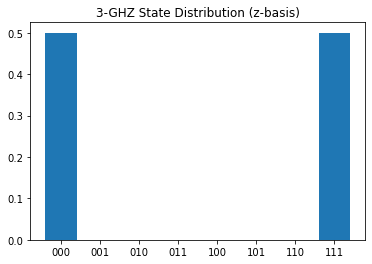

In [9]:
"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## HQN Training
We will construct the bases we want as a list of `L x 3` rotation-parameter matrices, then pass them into the hybrid quantum net and run the optimization algorithm. 

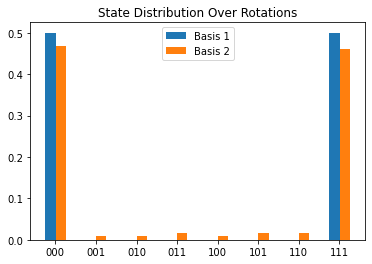

In [10]:
# Preparation of two bases
init_basis = t.zeros(state.num_qubits, 3) # z-basis
perturbation = init_basis.clone()
perturbation[:,0] += pi/10 * t.ones(state.num_qubits) # small rotation in one axis for each qubit
perturbed_basis = init_basis + perturbation
bases = [init_basis, perturbed_basis]
num_bases = len(bases)

# Visualize the distribution of the bases
fig, ax = plt.subplots()
for i, basis in enumerate(bases):
    dist_i = BasisTransformer([state], basis).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.04*state.num_qubits, dist_i, width=0.25)
    bar.set_label(f"Basis {i+1}")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.title("State Distribution Over Rotations")
plt.show()

Classical deep net of circuit depth 0 initialized.
Classical deep net of circuit depth 0 initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
3-qubit non-regularized 'NFT' hybrid quantum net initialized -- Hello world!


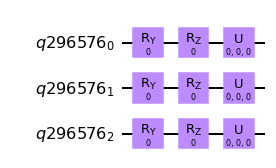

In [14]:
# Start up the HQN
disp = False # Display convergence messages from optimizer

hqn = HQNet(state, bases, eta=0.05, maxiter=5000, disp=disp,
            mode='NFT', depth=CIRCUIT_DEPTH, 
            metric_func=KL, regularize=False)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [15]:
# Optimize a few times.
NRUN = 10
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim))
avg = 0
que_avg = 0
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss, regularizer_loss, que_number = hqn.find_potential_symmetry(print_log=True)
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
    que_avg += que_number
print(f"\nAverage loss: {avg}")
print("average query number = ", que_avg/NRUN)

# ? | Ooen question: `regularizer_loss` gives a list (one element per basis) of losses over time
# ? | that the regularizer CNets report during their batch training. These can be plotted
# ? | to see how well the regularizer is learning. In particular, if the paths start out in
# ? | totally different parts of the manifold, does the regularizer learn it well? If so, we 
# ? | are in trouble. We want the CNets to intentionally overfit, so it extrapolates relatively
# ? | poorly.

Optimized to QKL = 0.00816910620778799
Queried loss func 5001 times
Optimized to QKL = 0.01118861511349678
Queried loss func 5001 times
Optimized to QKL = 0.009221009910106659
Queried loss func 5001 times
Optimized to QKL = 0.011188637465238571
Queried loss func 5001 times
Optimized to QKL = 0.013861370272934437
Queried loss func 5001 times
Optimized to QKL = 0.015138912945985794
Queried loss func 5001 times
Optimized to QKL = 0.014969294890761375
Queried loss func 5001 times
Optimized to QKL = 0.019102443009614944
Queried loss func 5001 times
Optimized to QKL = 0.014921157620847225
Queried loss func 5001 times
Optimized to QKL = 0.011188605800271034
Queried loss func 5001 times

Average loss: 0.012894915323704481
average query number =  5001.0


### Scalability of query number with respect to cubit number

state: xy, layer 0
3: 744.1

4: 1562, with loss 0.03
5: 2237.4 with loss 0.15
6: 3213, with loss 0.03
7: 5694  with loss 0.17


### Summary of findings
tl;dr Nelder-Mead and NFT works best

We define `LA = A | B` to be the average loss `A` over `B` runs, throwing out extreme outliers. Times given are per run. The below results are for the 3-qubit GHZ state.

#### Local optimizers
1. Vanilla gradient descent is extremely slow (`~3 min`) and performs moderately poorly (`LA = 0.021 | 100`)
2. Adam is super fast (`<1 sec`) but performs very poorly (`LA = 3.77 | 1000`)
3. Nelder-Mead is very fast (`~5 sec`) and performs very well, needs `~1000` queries (`LA = 1e-14 | 100`).
4. Conjugate gradient is super fast (`<1 sec`) but performs very poorly (`LA = 3.171 | 1000`)
5. NFT is very fast (`~5 sec`) and performs well (`LA = 1e-5 | 100`).
6. SPSA is very slow (`~40 sec`) and performs reasonably well (`LA = 0.0036 | 100`)
7. TNC is extremely fast (`<<1 sec`) but performs very poorly (`LA = 3.62 | 1000`)
8. AQGD: I cannot get it to run. Seems like they are running some strange batch training which is not compatible
with my loss function `param_to_quantum_loss`. Too bad.

#### Global optimizers
1. TODO

When 3 cubit, 0 layer:
1. Nelder Mead: 0.15
2. Adam: 1.6
3.



## Quantum Training Validation
The quantum loss function is a sum over the classical loss metric projected into each basis, so let's first make sure that
the loss is uniformly and sufficiently small in each of the bases we used in the search.

In [ ]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape(param_shape)}\n")
    for basis_here in bases:
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for training basis {basis_here[0]} is: {loss_metric}")

Analysing proposed symmetry 1:
tensor([[[ 2.1359e+00,  3.1675e+00]],

        [[-2.3675e-04, -4.3867e-02]],

        [[-2.3634e-04, -4.3816e-02]],

        [[ 6.2829e+00,  6.2394e+00]],

        [[ 4.0967e+00,  3.3063e+00]],

        [[ 3.7213e+00,  3.2530e+00]],

        [[ 6.2817e+00,  5.8633e+00]]])

	Loss metric for training basis tensor([0., 0., 0.]) is: 0.0003004279685207838
	Loss metric for training basis tensor([0.3142, 0.0000, 0.0000]) is: 0.000273525117173424


Analysing proposed symmetry 2:
tensor([[[ 2.1632e+00,  2.6062e+00]],

        [[ 4.0942e+00,  9.3740e+00]],

        [[ 4.0942e+00,  3.0898e+00]],

        [[-2.5197e-03,  6.4417e+00]],

        [[-2.5386e-03,  6.4419e+00]],

        [[ 6.2735e+00,  4.7276e-01]],

        [[ 2.9575e+00,  3.0563e+00]]])

	Loss metric for training basis tensor([0., 0., 0.]) is: 0.023069885292382776
	Loss metric for training basis tensor([0.3142, 0.0000, 0.0000]) is: 0.02160676459202861


Analysing proposed symmetry 3:
tensor([[[ 2.1631e+

## Quantum Loss Cross-Validation
We chose a small number of bases to run the quantum loss scheme over. But are those bases enough? 
If the proposed symmetries are truly symmetries, then they will be a symmetry in every basis. We shall test
these proposed symmetries by choosing some random bases, applying the quantum circuit, and examining the loss metric there.

If the loss metric is high there, then we did not use enough bases in the quantum loss function.

Note that this has more general implications, as the number of bases necessary to achieve a good quantum loss function
informs the amount of information necessary to construct a reasonable tomography of the state.

In [ ]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape(param_shape)}\n")
    for _ in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, basis_param=basis_here, depth=CIRCUIT_DEPTH, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for random basis {basis_here[0].numpy()} is: {loss_metric}")
    print('\n')

Analysing proposed symmetry 1:
tensor([[[ 2.1359e+00,  3.1675e+00]],

        [[-2.3675e-04, -4.3867e-02]],

        [[-2.3634e-04, -4.3816e-02]],

        [[ 6.2829e+00,  6.2394e+00]],

        [[ 4.0967e+00,  3.3063e+00]],

        [[ 3.7213e+00,  3.2530e+00]],

        [[ 6.2817e+00,  5.8633e+00]]])

	Loss metric for random basis [1.1417098 4.059915  1.0541157] is: 0.08319255604902176
	Loss metric for random basis [0.92853814 3.6686778  3.6113338 ] is: 0.02910342642174948
	Loss metric for random basis [1.5625513 1.1438609 5.848424 ] is: 0.1250959834663135




Analysing proposed symmetry 2:
tensor([[[ 2.1632e+00,  2.6062e+00]],

        [[ 4.0942e+00,  9.3740e+00]],

        [[ 4.0942e+00,  3.0898e+00]],

        [[-2.5197e-03,  6.4417e+00]],

        [[-2.5386e-03,  6.4419e+00]],

        [[ 6.2735e+00,  4.7276e-01]],

        [[ 2.9575e+00,  3.0563e+00]]])

	Loss metric for random basis [1.4444362 3.6681762 1.4581387] is: 0.4056410539761828
	Loss metric for random basis [0.56317055